# Capstone Project - Analyzing King County Crime using Geographic Data

## Introduction

The main goal of this project is to use location data from FourSqure to analyze King County Crime. Crime rate has increased significantly for the past few years in King County, WA due to drug abuses and pricey housing. The ideas is to see if we could estimate the crime based on the location characteristics such as venues around the neighborhood. For example, we want to answer question like would crime more or less likely to happen in neighborhood with more venues of certain type? The report could be used for the following purposes for example:

* House buyers or renters who want to settle in relatively safe neighborhood can use this as a rough guidance by examining the surrounding venues.
* Optimize allocation of police patrol resources based on surroundings in the locations.
* Optimize use of County funds to improve public safety.

## Part I - Data Description:

There are four main data sources used in this project.

* **King County Population by City**: http://worldpopulationreview.com/us-counties/wa/king-county-population/
* **King County Sheriff's Office Crime Data**:  https://moto.data.socrata.com/dataset/King-County-Sheriff-s-Office/4h35-4mtu
* **Simplemaps Geographic Data**: https://simplemaps.com/data/us-cities
* **FourSqure API Location Data**: http://www.foursquare.com

The population data is mainly used to normalized the crime data. The latest estimated population available by city within the county is 2016. We then extract the the population growth for 2017 and 2018 to project the population by city to 2018. The Crime data is at the incident level. We aggregate it to the city level to calculate the number of crimes and then merge it with the Population data. The Geographic Data has the list of U.S. cities with their latitudes and longitudes. We then attach it to the dataset and finally we bring in the venues data from FourSqure using the lat/long information.



## Part II- Data Preparation

### Install & Load Packages for Data Pre-Processing

In [11]:
! pip install lxml
! pip install html5lib
! pip install BeautifulSoup4
! pip install tabulate

     |████████████████████████████████| 5.8MB 26.7MB/s eta 0:00:01
     |████████████████████████████████| 102kB 18.4MB/s ta 0:00:01
     |████████████████████████████████| 51kB 7.4MB/s eta 0:00:011
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/e1/41/5e/e201f95d90fc84f93aa629b6638adacda680fe63aac47174ab
Successfully built tabulate


In [12]:
from bs4 import BeautifulSoup
from tabulate import tabulate
import pandas as pd
import requests

### First, load the King County population data by city
The dataset is provided World Population Review. It's the 16th table on the webpage

In [20]:
res = requests.get("http://worldpopulationreview.com/us-counties/wa/king-county-population/")
soup = BeautifulSoup(res.content,'lxml')
Pop_table = soup.find_all('table')[15] 
King_Pop = pd.read_html(str(Pop_table))
King_Pop = pd.DataFrame(King_Pop[0])
King_Pop.head()

,City,2010 Census,2016 Estimated,Growth,Growth Rate
0,Seattle,608659,704352,95693,15.72%
1,Bellevue,127887,141400,13513,10.57%
2,Kent,118593,127514,8921,7.52%
3,Renton,91900,100953,9053,9.85%
4,Federal Way,89306,96757,7451,8.34%


The population growth has slowed down quite a bit since 2016, so the Growth Rate (after annualized) in the table above will be misleading. Instead, we can apply the actual Growth Rate in the most recent years.

### Load the population growth table

In [21]:
res = requests.get("http://worldpopulationreview.com/us-counties/wa/king-county-population/")
soup = BeautifulSoup(res.content,'lxml')
Pop_table_growth = soup.find_all('table')[0] 
King_Pop_growth = pd.read_html(str(Pop_table_growth))
King_Pop_growth = pd.DataFrame(King_Pop_growth[0])
King_Pop_growth.head()

,Year,Population,Growth,Growth Rate
0,2018,2233163,28934.0,1.31%
1,2017,2204229,37627.0,1.74%
2,2016,2166602,40041.0,1.88%
3,2015,2126561,40831.0,1.96%
4,2014,2085730,38187.0,1.87%


Extract the 2017 & 2018 population growth. Notice here we will apply a uniform Growth Rate to each city within the County.

In [22]:
gr_2018 = King_Pop_growth[King_Pop_growth['Year'] == 2018]['Growth Rate']
gr_2018 = gr_2018.str.slice(stop=4)
gr_2018 = pd.to_numeric(gr_2018)
gr_2018 = gr_2018.iloc[0]

gr_2017 = King_Pop_growth[King_Pop_growth['Year'] == 2017]['Growth Rate']
gr_2017 = gr_2017.str.slice(stop=4)
gr_2017 = pd.to_numeric(gr_2017)
gr_2017 = gr_2017.iloc[0]

print('2018 Population Growth is ', gr_2018)
print('2017 Population Growth is ', gr_2017)

2018 Population Growth is  1.31
2017 Population Growth is  1.74


Now we apply the Population Growth to the 2016 estimated population to project the 2018 population

In [23]:
King_Pop['Population_2018'] = round(King_Pop['2016 Estimated']*(1+gr_2017/100)*(1+gr_2018/100),0).astype(int)
King_Pop.head()                                            

,City,2010 Census,2016 Estimated,Growth,Growth Rate,Population_2018
0,Seattle,608659,704352,95693,15.72%,725995
1,Bellevue,127887,141400,13513,10.57%,145745
2,Kent,118593,127514,8921,7.52%,131432
3,Renton,91900,100953,9053,9.85%,104055
4,Federal Way,89306,96757,7451,8.34%,99730


Now only Keep the data we need, City and Population

In [24]:
King_Pop_Table_Final = King_Pop[['City', 'Population_2018']]
King_Pop_Table_Final['City'] = King_Pop_Table_Final['City'].str.upper()
King_Pop_Table_Final.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,City,Population_2018
0,SEATTLE,725995
1,BELLEVUE,145745
2,KENT,131432
3,RENTON,104055
4,FEDERAL WAY,99730


### Now, we can load the Crime data
The dataset is provided by the King County Sheriff's Office. The link to the data is here: https://moto.data.socrata.com/dataset/King-County-Sheriff-s-Office/4h35-4mtu

The data consists of incidents reported from Jan to August 2019 by city within the King Country.

In [25]:
Crime_df = pd.read_csv('King_County_Sheriff_s_Office.csv')
Crime_df.head()

,incident_id,case_number,incident_datetime,incident_type_primary,incident_description,clearance_type,address_1,address_2,city,state,zip,country,latitude,longitude,created_at,updated_at,location,hour_of_day,day_of_week,parent_incident_type
0,900679131,C18031959,07/18/2018 07:40:00 PM,222 - DEATH INVESTIGATION,222 - DEATH INVESTIGATION,NaN,23400 Block NE NOVELTY HILL RD,NaN,REDMOND,WA,98053.0,NaN,47.700164,-122.025936,01/10/2019 11:50:25 PM,02/20/2019 11:31:40 PM,POINT (-122.0259356 47.7001638),19,Wednesday,Death
1,900663765,C18032029,07/18/2018 08:00:30 PM,"274 - BURGLARY, RESIDENTIAL","274 - BURGLARY, RESIDENTIAL",NaN,7700 Block 196TH AVE NE,NaN,REDMOND,WA,98053.0,NaN,47.672835,-122.076323,01/10/2019 08:03:57 PM,02/20/2019 11:18:49 PM,POINT (-122.076323 47.672835),20,Wednesday,Breaking & Entering
2,900663425,C18031955,07/18/2018 08:25:34 PM,227 - OBSTRUCTING AN OFFICER,227 - OBSTRUCTING AN OFFICER,NaN,SW ROXBURY ST & 15TH AVE SW,NaN,SEATTLE,WA,98106.0,NaN,47.517348,-122.354009,01/10/2019 07:59:04 PM,02/20/2019 11:15:21 PM,POINT (-122.3540088 47.51734829999999),20,Wednesday,Other
3,900679110,C18032406,07/18/2018 08:41:07 PM,"300 - THEFT, VEHICLE","300 - THEFT, VEHICLE",NaN,13400 Block SE 141ST ST,NaN,RENTON,WA,98059.0,NaN,47.475086,-122.159465,01/10/2019 11:50:25 PM,02/20/2019 11:31:41 PM,POINT (-122.1594654 47.4750858),20,Wednesday,Theft of Vehicle
4,900663729,C18031993,07/18/2018 08:45:45 PM,334 - VANDALISM UNDER $1500,334 - VANDALISM UNDER $1500,NaN,35700 Block 26TH AVE S,NaN,FEDERAL WAY,WA,98003.0,NaN,47.281400,-122.300761,01/10/2019 08:03:57 PM,02/20/2019 11:18:49 PM,POINT (-122.3007612 47.2813998),20,Wednesday,Property Crime


Extract the Case Number and City from the table to calculate number of crimes.

In [26]:
Crime_df_tbl= Crime_df[['city', 'case_number']]
Crime_df_tbl.head()

,city,case_number
0,REDMOND,C18031959
1,REDMOND,C18032029
2,SEATTLE,C18031955
3,RENTON,C18032406
4,FEDERAL WAY,C18031993


Calculate the number of crimes by city and rename the columns.

In [28]:
Crime_df_Final = Crime_df_tbl.groupby('city', as_index=False).count()
Crime_df_Final = Crime_df_Final.rename(columns={'city': 'City', 'case_number': 'Number_of_Crimes'})
Crime_df_Final.head()

,City,Number_of_Crimes
0,ABERDEEN,1
1,ALGONA,7
2,ASTORIA,1
3,AUBURN,1590
4,BARING,18


Now we are ready to join the Population table with the Crime Number Table. We use inner join to avoid NA in Number of Crimes in the final table when crime data is not available. We end up dropping 5 cities where we don't have any crime information.

In [29]:
Pop_Crime_df = pd.merge(King_Pop_Table_Final, Crime_df_Final, on = 'City', how = 'inner')
Pop_Crime_df.head(10)

,City,Population_2018,Number_of_Crimes
0,SEATTLE,725995,6662
1,BELLEVUE,145745,65
2,KENT,131432,1032
3,RENTON,104055,1818
4,FEDERAL WAY,99730,443
5,KIRKLAND,90396,25
6,AUBURN,79853,1590
7,SAMMAMISH,65733,62
8,REDMOND,64377,520
9,SHORELINE,57033,77


Not surprisingly higher population means more crimes. Next, we need to calculate the crime rate per 100,000 population, which is a pretty standard way to look at crime rate.

In [219]:
Pop_Crime_df['Crime_per_100K'] = Pop_Crime_df['Number_of_Crimes']/Pop_Crime_df['Population_2018']*10000
Pop_Crime_Final = Pop_Crime_df[['City', 'Crime_per_100K']]
Pop_Crime_Final.head()

,City,Crime_per_100K
0,SEATTLE,91.763717
1,BELLEVUE,4.459844
2,KENT,78.519691
3,RENTON,174.715295
4,FEDERAL WAY,44.419934


Before we move on to attaching location data. Let's visualize which city has the highest crime rate.

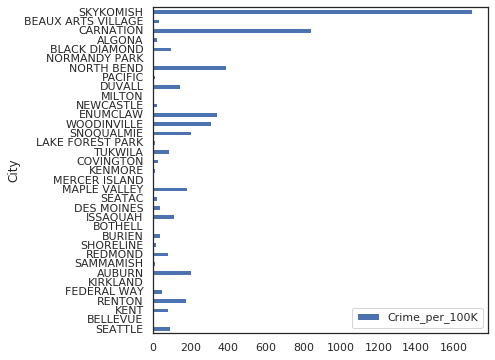

In [221]:
ax = Pop_Crime_Final.plot.barh(x='City', y='Crime_per_100K')

### Attach Geographic data

We are now ready to attach geographic data to the Pop_Crime dataset above. The lat-long data was provided by simplemaps. The link is here https://simplemaps.com/data/us-cities

Load the lat-long dataset:

In [31]:
Geo_df = pd.read_csv('uscities.csv')
Geo_df.head()

,city,city_ascii,state_id,state_name,county_fips,county_name,county_fips_all,county_name_all,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,South Creek,South Creek,WA,Washington,53053,Pierce,53053,Pierce,46.9994,-122.3921,2500.0,125.0,polygon,False,True,America/Los_Angeles,3,98580 98387 98338,1840116412
1,Roslyn,Roslyn,WA,Washington,53037,Kittitas,53037,Kittitas,47.2507,-121.0989,947.0,84.0,polygon,False,True,America/Los_Angeles,3,98941 98068 98925,1840097718
2,Sprague,Sprague,WA,Washington,53043,Lincoln,53043,Lincoln,47.3048,-117.9713,441.0,163.0,polygon,False,True,America/Los_Angeles,3,99032,1840096300
3,Gig Harbor,Gig Harbor,WA,Washington,53053,Pierce,53053,Pierce,47.3352,-122.5968,9507.0,622.0,polygon,False,True,America/Los_Angeles,3,98332 98335,1840097082
4,Lake Cassidy,Lake Cassidy,WA,Washington,53061,Snohomish,53061,Snohomish,48.0639,-122.0920,3591.0,131.0,polygon,False,True,America/Los_Angeles,3,98223 98258 98270,1840116371


Filter down to WA and King county only, keep columns needed and do some clearing to make future merge easier.

In [32]:
Geo_df_king = Geo_df[(Geo_df['state_id'] == 'WA') & (Geo_df['county_name'] == 'King')][['city', 'lat', 'lng']]
Geo_df_king = Geo_df_king.rename(columns={'city': 'City', 'lat': 'Latitude', 'lng': 'Longitude'})
Geo_df_king['City'] = Geo_df_king['City'].str.upper()
Geo_df_king = Geo_df_king.reset_index(drop = True)

Geo_df_king.head()


,City,Latitude,Longitude
0,VASHON,47.4122,-122.4726
1,SHORELINE,47.7564,-122.3426
2,DES MOINES,47.3914,-122.3154
3,SEATTLE,47.6211,-122.3244
4,CARNATION,47.6446,-121.9048


Finally Join the Pop_Crime data with the Geo data with lat & long attached.

In [33]:
Pop_Crime_Geo_df = pd.merge(Pop_Crime_Final, Geo_df_king, on = 'City', how = 'inner')
Pop_Crime_Geo_df.head()

,City,Crime_per_100K,Latitude,Longitude
0,SEATTLE,917.6,47.6211,-122.3244
1,BELLEVUE,44.6,47.5953,-122.1550
2,KENT,785.2,47.3887,-122.2128
3,RENTON,1747.2,47.4758,-122.1905
4,FEDERAL WAY,444.2,47.3090,-122.3359


Notice how the Crime_per_100K value varies even after we normalized it based on population. We also want to standardize this variable based on the maximum value.

In [34]:
Pop_Crime_Geo_df['Crime_per_100K_std'] = round(Pop_Crime_Geo_df['Crime_per_100K']/Pop_Crime_Geo_df['Crime_per_100K'].max(),4)
Pop_Crime_Geo_df.head()

,City,Crime_per_100K,Latitude,Longitude,Crime_per_100K_std
0,SEATTLE,917.6,47.6211,-122.3244,0.0540
1,BELLEVUE,44.6,47.5953,-122.1550,0.0026
2,KENT,785.2,47.3887,-122.2128,0.0462
3,RENTON,1747.2,47.4758,-122.1905,0.1029
4,FEDERAL WAY,444.2,47.3090,-122.3359,0.0262


### Attach FourSqure API data

In [35]:
CLIENT_ID = 'HMM04OVGKUVJBTDUYYOSAEDYSF3TMVQQPOYT5WFAN3QA0UW4' # your Foursquare ID
CLIENT_SECRET = 'BJY5C01WWSJP2DI15TMADEB5YLRSMGF55RG3M4YFWYU1IOAM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [36]:
# FourSquare parameters
radius = 1000 # 1 km around the neighborhood center
limit = 200

venues = []

for lat, long, neighborhood in zip(Pop_Crime_Geo_df['Latitude'], Pop_Crime_Geo_df['Longitude'], Pop_Crime_Geo_df['City']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        limit)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [37]:
# Create dataframe for venues
venues_df = pd.DataFrame(venues)
venues_df.columns = ['City', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueType']
print(venues_df.shape)
venues_df.head()

(1008, 7)


,City,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueType
0,SEATTLE,47.6211,-122.3244,Analog Coffee,47.620768,-122.325448,Coffee Shop
1,SEATTLE,47.6211,-122.3244,Tacos Chukis,47.620520,-122.321516,Taco Place
2,SEATTLE,47.6211,-122.3244,Glo's,47.619366,-122.324605,Breakfast Spot
3,SEATTLE,47.6211,-122.3244,Scream Salon,47.621000,-122.321442,Salon / Barbershop
4,SEATTLE,47.6211,-122.3244,b~side,47.620753,-122.325622,Food Stand


Get dummy variables for each venue type and calculate the occurrences

In [38]:
## Create dummy for venue type
venues_type_onehot = pd.get_dummies(venues_df[['VenueType']], prefix="", prefix_sep="")
venues_type_onehot['City'] = venues_df['City']
fix_columns = list(venues_type_onehot.columns[-1:]) + list(venues_type_onehot.columns[:-1])
venues_type_onehot = venues_type_onehot[fix_columns]

## Calculate sum
venue_df_final = venues_type_onehot.groupby(['City']).sum().reset_index()
venue_df_final.head()

,City,ATM,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,...,Used Bookstore,Vape Store,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,ALGONA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUBURN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,BEAUX ARTS VILLAGE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,BELLEVUE,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,BLACK DIAMOND,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Finally, we can combine everything we've got so far to generate the final dataframe.

In [39]:
## get City and Crime 
Pop_Crime_Geo_df_keep = Pop_Crime_Geo_df[['City', 'Crime_per_100K_std']]

## merge with the Venue df above

In [40]:
Pop_Crime_Geo_Venue_df = pd.merge(venue_df_final, Pop_Crime_Geo_df_keep, on = 'City', how = 'inner')
Pop_Crime_Geo_Venue_df.head()

,City,ATM,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,...,Vape Store,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Crime_per_100K_std
0,ALGONA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0127
1,AUBURN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.1173
2,BEAUX ARTS VILLAGE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0175
3,BELLEVUE,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.0026
4,BLACK DIAMOND,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0560


## Part III - Models

### Correlation Matrix

Before we start building any models. Let's visualize the correlation matrix on the heat map

In [41]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

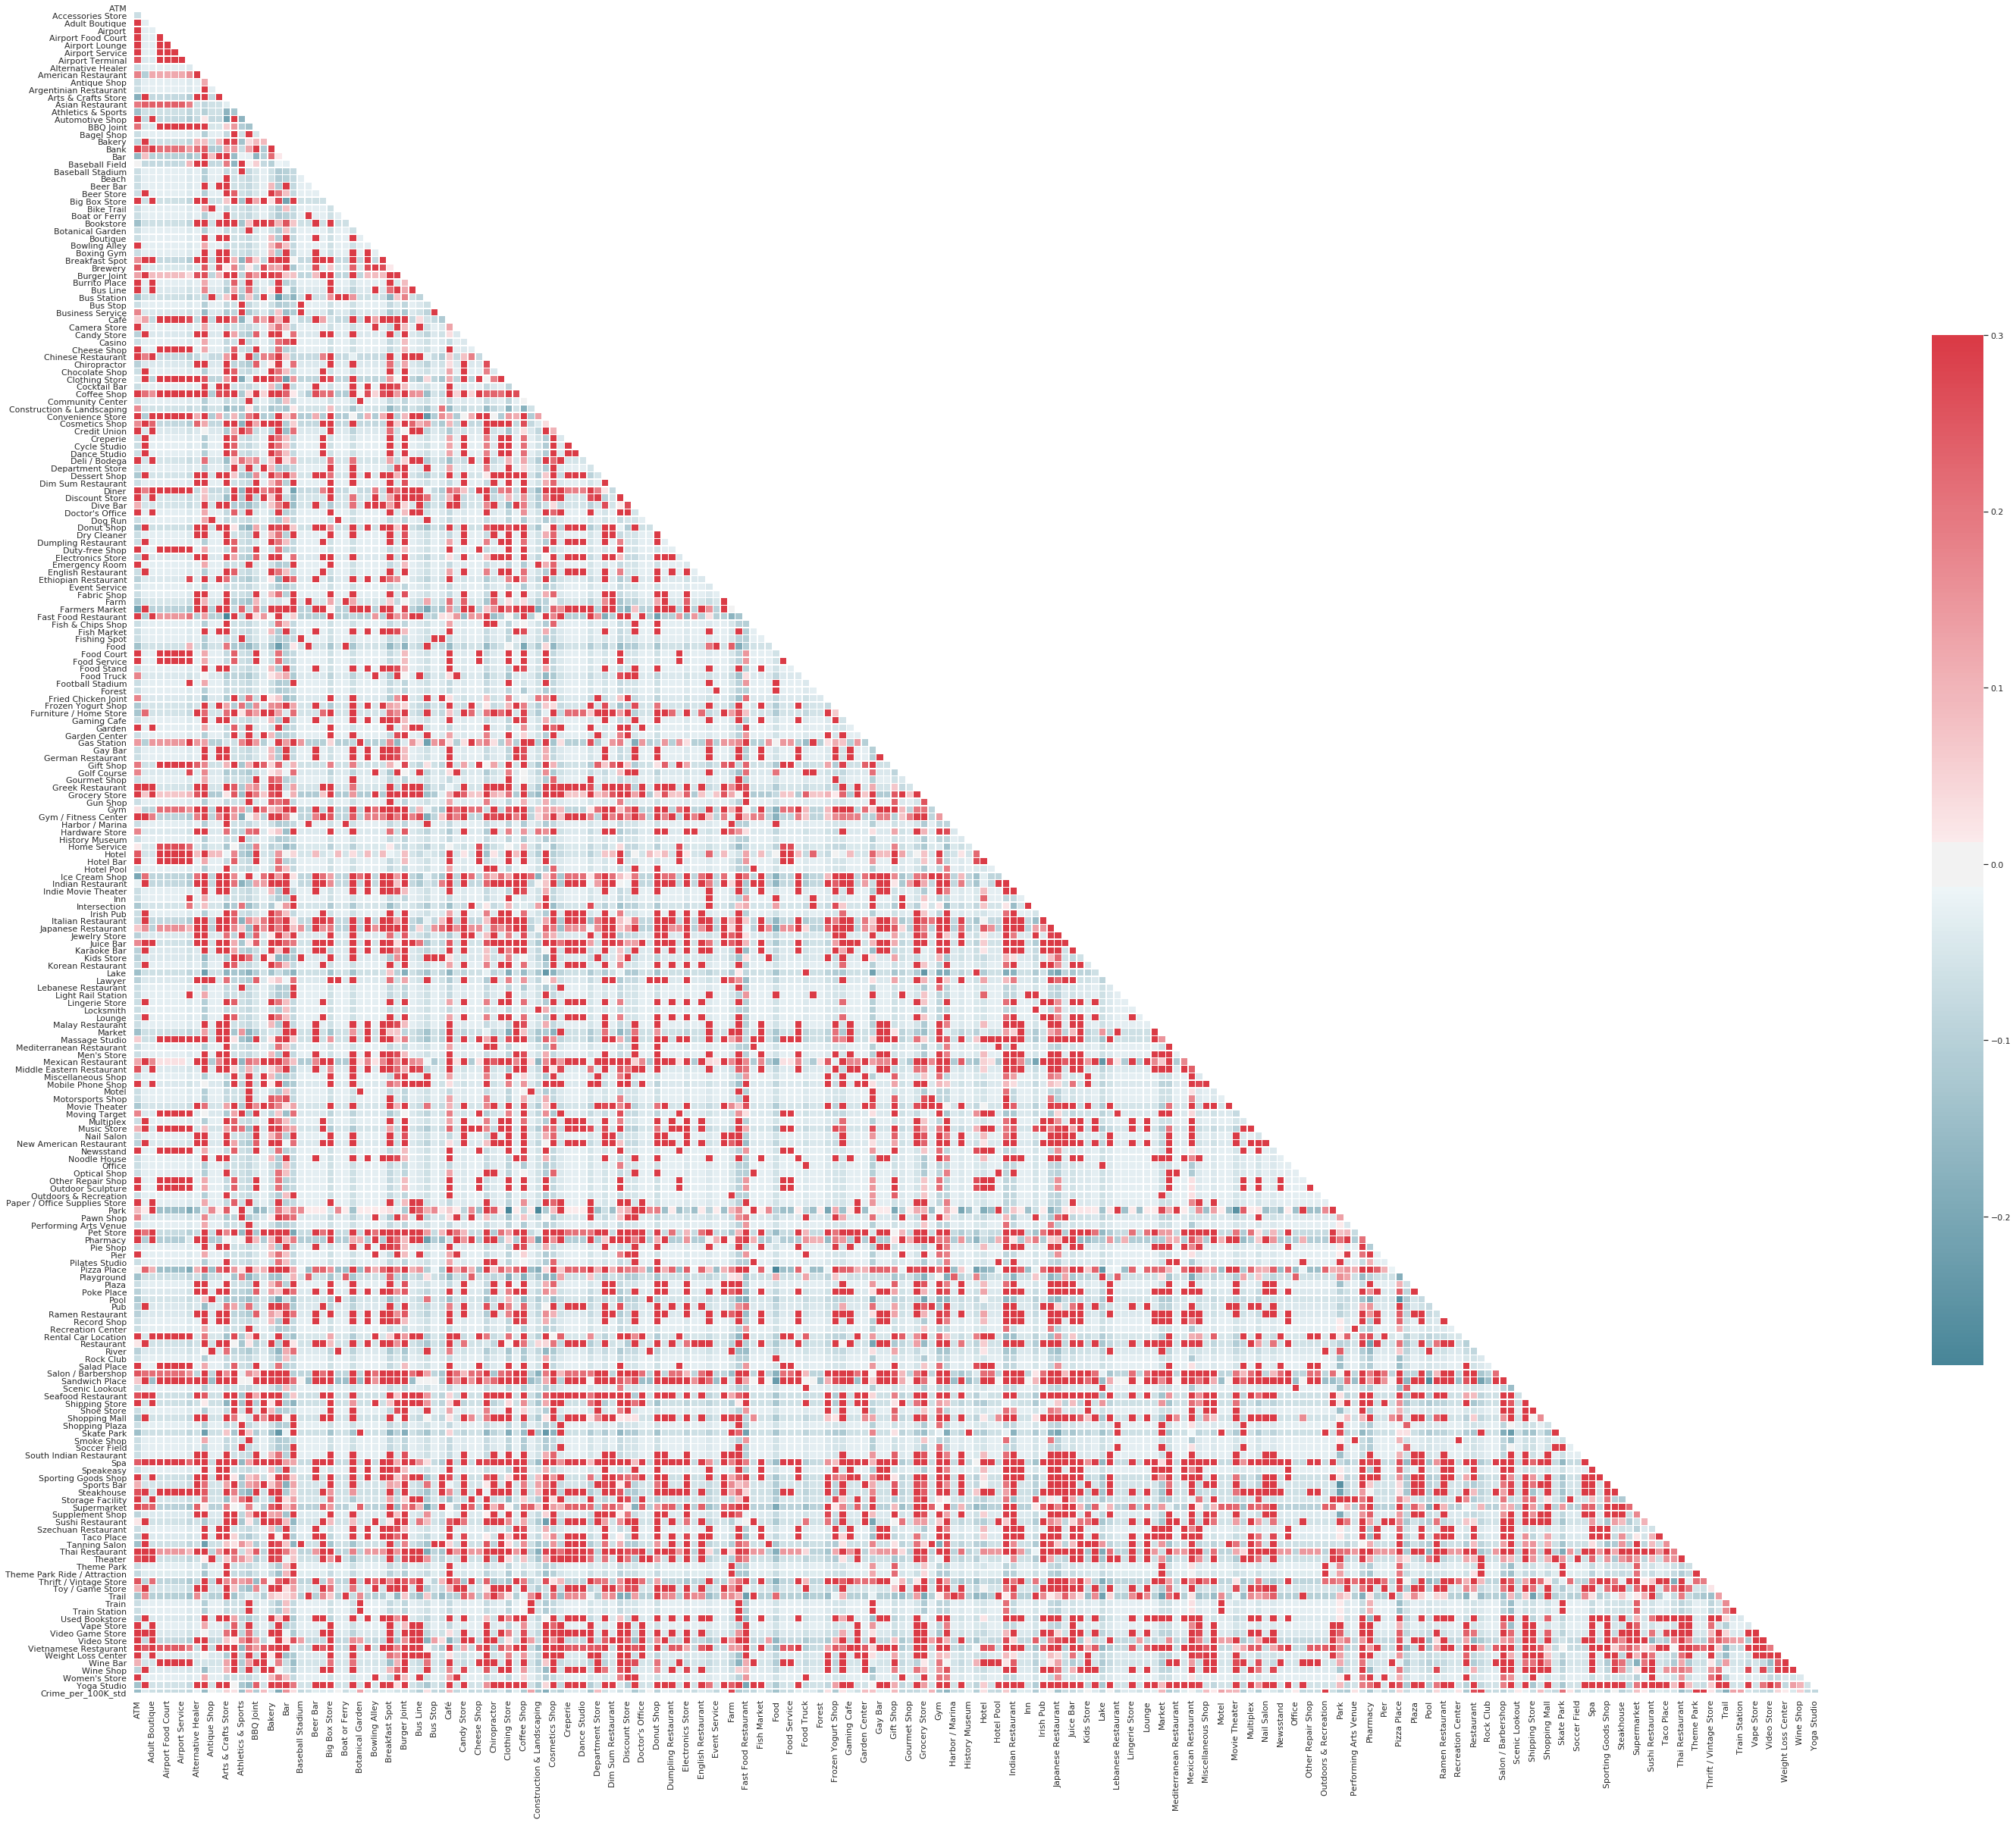

In [47]:
## remove first column City
df_for_corr = Pop_Crime_Geo_Venue_df.loc[:, Pop_Crime_Geo_Venue_df.columns != 'City']
sns.set(style="white")

## compute correlation matrix
corr = df_for_corr.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(50, 50))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Split Data into Training & Validation

In [103]:
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
import matplotlib

In [76]:
X = df_for_corr.loc[:, df_for_corr.columns != 'Crime_per_100K_std']
y = df_for_corr[['Crime_per_100K_std']]
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

### Ridge Regression

Here we do a cross-validation to choose the tuning parameter alpha. The code below yields the alpha value that results in the smallest CV error.

In [77]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.001

In [80]:
ridge = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge.fit(X_train, y_train)
round(mean_squared_error(y_test, ridge.predict(X_test)), 4)

0.0547

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

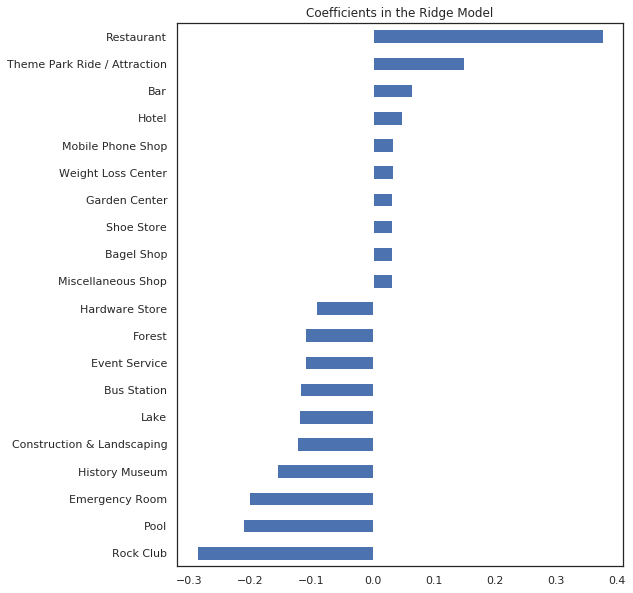

In [109]:
coeff_ridge = pd.Series(ridge.coef_[0], index = X_train.columns)

imp_coef = pd.concat([coeff_ridge.sort_values().head(10),
                     coeff_ridge.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

### Principle Component Analysis

First, we need to obtain the principle components thru PCA.

In [179]:
# First, apply PCA
from sklearn.decomposition import PCA
pca = PCA(svd_solver='auto', random_state=0)
X_pca = pca.fit_transform(scale(X))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


Then we apply ridge regression to the principle components.

In [198]:
X_train_pca, X_test_pca , y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.5, random_state=1)

Now we can apply a simple linear regression to the principle components.

In [209]:
n_component_list = range(1, 17)
r2_list = []
mse_list = []

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
for i in n_component_list:
    lreg = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:i], y, test_size=0.5, random_state=0)
    model = lreg.fit(X_train, y_train)
    # check the result
    y_pred = lreg.predict(X_test)
    r2 = r2_score(y_test, y_pred) # r2 score
    mse = mean_squared_error(y_test, y_pred) # mse
    r2_list.append(r2)
    mse_list.append(mse)
    
scores_df = pd.DataFrame.from_dict(dict([('NComponents', n_component_list),
                                        ('R_squred', r2_list),
                                        ('MSE', mse_list)]))
scores_df.set_index('NComponents', inplace=True)

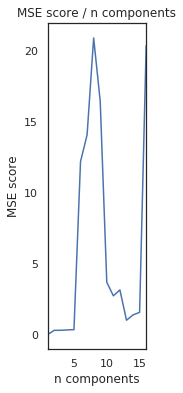

In [213]:
# plot the MSE to see the best n_components

plt.subplot(1, 3, 3)
scores_df['MSE'].plot(kind='line')
plt.title('MSE score / n components')
plt.ylabel('MSE score')
plt.xlabel('n components')

plt.show()

In [214]:
mse_min = scores_df['MSE'].idxmin()
print("Best n:", mse_min, "MSE:", scores_df['MSE'][mse_min])

Best n: 1 MSE: 0.05686026450900207


In [222]:
# Use the best n_components parameter
lreg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:r2_max], y, test_size=0.5, random_state=0)
model = lreg.fit(X_train, y_train)

# check the result
y_pred = lreg.predict(X_test)
mse = mean_squared_error(y_test, y_pred) # mse
print("MSE:", round(mse,4))

MSE: 0.0569


This does not seem to be better over the Ridge regression above.

## Part IV - Conclusion

Crime rate seems to be correlated with the venues data. We have tested Ridge regression and Principle Component regression on the dataset. Ridge regression seems to be better in terms of prediction. In addition, Ridge regression also yields interpretable results where we could see the most predictive features associated with crime rate. From the list of variables by Ridge regression, it's not surprising that venues that people visit on daily basis will have more crimes, whereas places that people don't visit regularly (bus station) have less crimes.